# Обучение эмбеддингов (Metric Learning)

Задание: Обучить сиамскую сеть для верификации лиц на датасете LFW

Библиотеки: [Python, Tensorflow]

## Переключение версии TensorFlow

In [ ]:
%tensorflow_version 2.x

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import numpy as np
import pandas as pd

## Загрузка и подготовка датасета LFW

In [ ]:
(train_data, test_data), data_info =  tfds.load('lfw', 
                                      as_supervised=True, 
                                      with_info=True, 
                                      split=['train[:90%]', 
                                            'train[90%:]'],
                                      )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteAIBOA8/lfw-train.tfrecord


  0%|          | 0/13233 [00:00<?, ? examples/s]

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [ ]:
data_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [ ]:
for i in train_data.take(1):
    print(i)

## Визуализация датасета

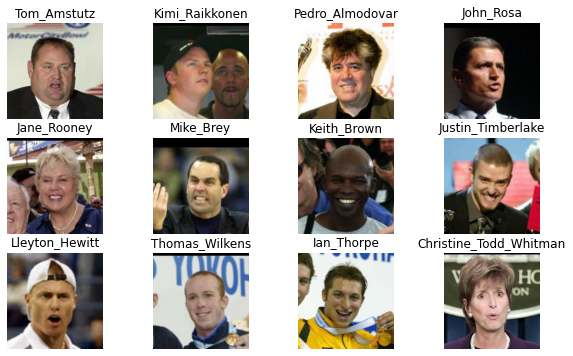

In [ ]:
plt.figure(figsize=(10, 6))
for i, el in enumerate(train_data.take(12)):
    plt.subplot(3, 4, i+1)
    plt.title(el[0].numpy().decode('utf-8'))
    plt.imshow(el[1])
    plt.axis('off')

## Создание модели CNN

In [ ]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [ ]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [ ]:
IMAGE_SIZE = (250,250)
NUM_EPOCHS = 50
BATCH_SIZE = 64

In [ ]:
def preprocess(label, img):
    
    #img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, dtype=tf.float32) / 255.
    return label, img


In [ ]:
train_ds = train_data.shuffle(buffer_size=len(train_data),seed=123).map(preprocess).repeat(NUM_EPOCHS).batch(BATCH_SIZE)

In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None))>

In [ ]:
test_ds = test_data.map(preprocess).batch(256)

In [ ]:
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None))>

## Подготовка к обучению

In [ ]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [ ]:
%%time

test_labels, test_images = next(iter(test_ds))
train_loss, test_loss = [], []

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        test_embs = model(test_images)
        val_loss = contastive_loss(test_embs, test_labels)
        
        train_loss.append(loss_value)
        test_loss.append(val_loss)
        print(f'[{iteration}] \t train_loss: {loss_value.numpy()} \t val_loss: {val_loss.numpy()}')

[0] train_loss: 0.0 val_loss: 0.0
[200] train_loss: 0.0 val_loss: 0.012657716870307922
[400] train_loss: 0.29179707169532776 val_loss: 0.10341086983680725
[600] train_loss: 0.018867477774620056 val_loss: 0.09986859560012817
[800] train_loss: 6.598448276519775 val_loss: 0.33972734212875366
[1000] train_loss: 0.0 val_loss: 0.07532394677400589
[1200] train_loss: 0.0 val_loss: 0.10535188764333725
[1400] train_loss: 0.1424139440059662 val_loss: 0.23028050363063812
[1600] train_loss: 0.5930017232894897 val_loss: 0.6765751838684082
[1800] train_loss: 0.06726546585559845 val_loss: 0.052963100373744965
[2000] train_loss: 0.3443496823310852 val_loss: 1.727044939994812
[2200] train_loss: 2.8199119567871094 val_loss: 0.09485040605068207
[2400] train_loss: 0.24311937391757965 val_loss: 0.2665427625179291
[2600] train_loss: 0.0 val_loss: 0.052021488547325134
[2800] train_loss: 1.5225238800048828 val_loss: 0.1441536545753479
[3000] train_loss: 7.147873878479004 val_loss: 1.0460758209228516
[3200] tra

## Получение эмбеддингов для тестовой выборки

In [ ]:
test_embs = model(test_images)

## Тестирование на новых данных (из теста)

In [ ]:
test_data = test_ds.take(1)
res = [(label, image) for label,image in test_data]
test_y = res[0][0].numpy()
test_x = res[0][1].numpy()
test_y[:25]

array([b'Francis_Collins', b'Jose_Luis_Santiago_Vasconcelos',
       b'Georgi_Parvanov', b'Donald_Rumsfeld', b'Kiki_Vandeweghe',
       b'Juan_Valencia_Osorio', b'Brian_StPierre', b'Jacques_Chirac',
       b'Silvio_Berlusconi', b'Andrew_Cuomo', b'Derek_Jeter',
       b'Colin_Powell', b'Gene_Orza', b'Adrien_Brody', b'Thomas_OBrien',
       b'Tiger_Woods', b'Steven_Tyler', b'Rolf_Eckrodt',
       b'Nicanor_Duarte_Frutos', b'Colin_Powell', b'Taha_Yassin_Ramadan',
       b'Michael_Douglas', b'Jefferson_Perez', b'Li_Zhaoxing',
       b'Camilla_Parker_Bowles'], dtype=object)

In [ ]:
[i for i, j in enumerate(test_y) if j == b'George_W_Bush']

[38, 53, 94, 126, 153, 155, 191, 198, 210]

In [ ]:
[i for i, j in enumerate(test_y) if j == b'Camilla_Parker_Bowles']

[24]

In [ ]:
[i for i, j in enumerate(test_y) if j == b'Vladimir_Putin']

[35, 196]

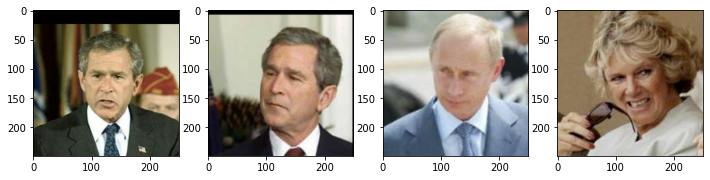

In [ ]:
img_a1 = test_x[38]*255
img_a2 = test_x[53]*255
img_b1 = test_x[35]*255
img_c1 = test_x[24]*255


fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(img_a1.astype("uint8"))
ax = fig.add_subplot(1, 4, 2)
ax.imshow(img_a2.astype("uint8"))
ax = fig.add_subplot(1, 4, 3)
ax.imshow(img_b1.astype("uint8"))
ax = fig.add_subplot(1, 4, 4)
ax.imshow(img_c1.astype("uint8"))
plt.show()

In [ ]:
new_embs = model(np.stack((img_a1, img_a2, img_b1, img_c1), axis=0))

def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb_a1 = new_embs[0,:]
emb_a2 = new_embs[1,:]
emb_b1 = new_embs[2,:]
emb_c1 = new_embs[3,:]

print('BUSH1 <-> BUSH2: ', diff(emb_a1, emb_a2))
print('BUSH1 <-> PUTIN1: ', diff(emb_a1, emb_b1))
print('BUSH2 <-> PUTIN1: ', diff(emb_a2, emb_b1))
print('BUSH1 <-> KAMILLA1: ', diff(emb_a1, emb_c1))
print('BUSH2 <-> KAMILLA1: ', diff(emb_a2, emb_c1))
print('PUTIN1 <-> KAMILLA1: ', diff(emb_b1, emb_c1))

BUSH1 <-> BUSH2:  1649.8190809903977
BUSH1 <-> PUTIN1:  2150.6680357507526
BUSH2 <-> PUTIN1:  1449.252738482836
BUSH1 <-> KAMILLA1:  1428.9116050337054
BUSH2 <-> KAMILLA1:  1169.0080196474273
PUTIN1 <-> KAMILLA1:  1036.0757694300162


Тестирование на данных из сети

In [ ]:
import imageio
from skimage.transform import resize

def load_and_prepare_image(fpath):
    img = imageio.imread(fpath)
    img = img.astype(np.float32) / 255.
    img = resize(img, (250, 250))
    return img

img_a1 = load_and_prepare_image('/content/a1.jpeg')
img_a2 = load_and_prepare_image('/content/a2.jpeg')
img_b1 = load_and_prepare_image('/content/b1.jpeg')

In [ ]:
img_b1.shape

(250, 250, 3)

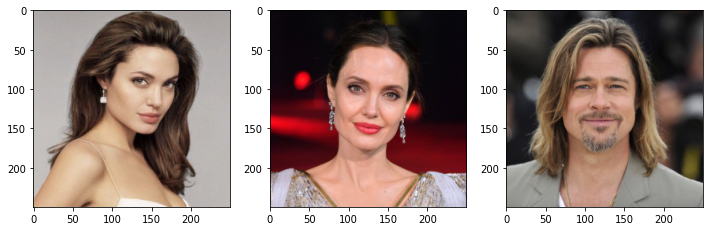

In [ ]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1)

plt.show()

In [ ]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

emb_a1 = new_embs[0,:]
emb_a2 = new_embs[1,:]
emb_b1 = new_embs[2,:]

print('JOLI1 <-> JOLI2: ', diff(emb_a1, emb_a2))
print('JOLI1 <-> PITT: ', diff(emb_a1, emb_b1))
print('JOLI2 <-> PITT: ', diff(emb_a2, emb_b1))

JOLI1 <-> JOLI2:  19.41104651497803
JOLI1 <-> PITT:  12.574624658522987
JOLI2 <-> PITT:  11.88612503138507
